# Bijective Maps from Simplicial Foliations

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri


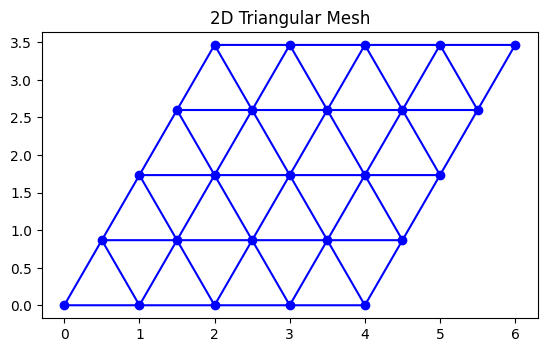

In [17]:
x, y = np.meshgrid(np.arange(5),np.arange(5))
x = x.flatten()
y = y.flatten()

rot60 = np.array([[1,0.5],[0,np.sqrt(0.75)]])
x0,y0 = rot60 @ np.vstack([x,y])
triang = mtri.Triangulation(x0, y0)

def plotTriangularMesh(triang):

    # 三角メッシュをプロット
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.triplot(triang, 'bo-')
    plt.title('2D Triangular Mesh')
    plt.show()

plotTriangularMesh(triang)

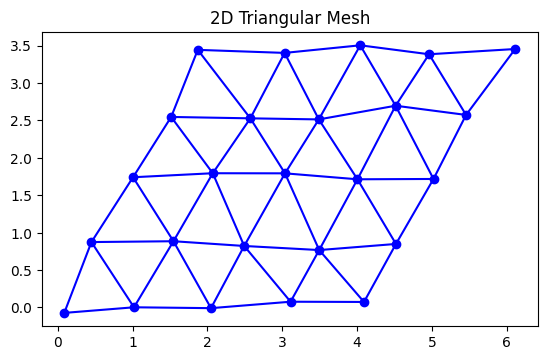

In [18]:
np.random.seed(0)

add_noise = lambda x: x + np.random.randn(len(x)) * 0.05

triang.x = add_noise(triang.x)
triang.y = add_noise(triang.y)

plotTriangularMesh(triang)

In [19]:
triang.triangles

array([[10, 11, 15],
       [21, 17, 22],
       [ 6, 11, 10],
       [16, 11, 12],
       [20, 15, 16],
       [12, 17, 16],
       [16, 15, 11],
       [17, 21, 16],
       [16, 21, 20],
       [ 8,  3,  4],
       [ 4,  9,  8],
       [ 5,  6, 10],
       [ 1,  5,  0],
       [ 6,  5,  1],
       [12, 11,  7],
       [11,  6,  7],
       [ 3,  8,  7],
       [ 7,  8, 12],
       [23, 19, 24],
       [ 6,  1,  2],
       [ 2,  7,  6],
       [ 3,  7,  2],
       [13,  8,  9],
       [12,  8, 13],
       [13, 17, 12],
       [ 9, 14, 13],
       [18, 23, 22],
       [22, 17, 18],
       [19, 23, 18],
       [18, 14, 19],
       [18, 13, 14],
       [17, 13, 18]], dtype=int32)

Calculate the Laplacian matrix for a given triangulation.

Parameters:
triang (Triangulation): The triangulation object containing the node coordinates and triangle indices.

Returns:
laplacian (numpy.ndarray): The Laplacian matrix.

ラプラシアン行列は、三角形分割された曲面上の離散ラプラス演算子を表す正方行列である。
メッシュ処理、画像処理、コンピュータグラフィックスなど様々なアプリケーションで使用される。

ラプラシアン行列は、三角形分割の各三角形に対して繰り返し処理を行うことで計算される。
各三角形について、辺の長さとコタンジェント値が計算されます。
ラプラシアン行列はこれらの値に基づいて更新されます。

ラプラシアン行列は次のように定義されます：

$$
L_{ij} = \begin{cases}
\sum_{k \in N(i)} \cot(\alpha_{ik}) + \cot(\beta_{ik}), & \text{if } i = j \\
-\cot(\alpha_{ij}), & \text{if } i \neq j \text{ and } (i, j) \text{ is an edge} \\
0, & \text{otherwise}
\end{cases}
$$

ここで、$N(i)$ は頂点 $i$ の隣人の集合、$\alpha_{ik}$ は辺 $(i, k)$ と反対側の角度である、
また、$\beta_{ik}$は辺$(i, k)$に隣接する三角形の辺$(i, k)$に対向する角度である。

注意: この関数は三角形分割が有効なドロネー三角形分割であることを仮定している。

Example usage:

```py
>>> triang = Triangulation(...)
>>> laplacian = calculate_laplacian(triang)
```


In [24]:
def calculate_laplacian(triang):
    # Get the node coordinates
    x = triang.x
    y = triang.y

    # Get the triangle indices
    triangles = triang.triangles

    # Initialize the Laplacian matrix
    laplacian = np.zeros([len(x), len(x)])

    # Iterate over each triangle
    for triangle in triangles:
        # Get the indices of the triangle vertices
        i, j, k = triangle

        # Calculate the edge lengths
        a = np.sqrt((x[j] - x[k])**2 + (y[j] - y[k])**2)
        b = np.sqrt((x[k] - x[i])**2 + (y[k] - y[i])**2)
        c = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)

        # Calculate the cotangent values
        cot_a = (b**2 + c**2 - a**2) / (4 * np.sqrt(3) * np.sqrt(b + c - a) * (c + a - b))
        cot_b = (c**2 + a**2 - b**2) / (4 * np.sqrt(3) * np.sqrt(c + a - b) * (a + b - c))
        cot_c = (a**2 + b**2 - c**2) / (4 * np.sqrt(3) * np.sqrt(a + b - c) * (b + c - a))

        # Update the Laplacian matrix
        laplacian[i, i] += cot_b + cot_c
        laplacian[j, j] += cot_c + cot_a
        laplacian[k, k] += cot_a + cot_b
        laplacian[i, j] -= cot_c
        laplacian[i, k] -= cot_b
        laplacian[j, i] -= cot_c
        laplacian[j, k] -= cot_a
        laplacian[k, i] -= cot_b
        laplacian[k, j] -= cot_a

    return laplacian

laplacian_matrix = calculate_laplacian(triang)
print(laplacian_matrix.shape)


(25, 25)


In [25]:
np.linalg.inv(laplacian_matrix)

array([[2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15],
       [2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.00159983e+15],
       [2.00159983e+15, 2.00159983e+15, 2.00159983e+15, 2.00159983e+15,
        2.0015

## Folations

```py
def generate_algorithm(tetrahedral_mesh):

    for each tetrahedron in tetrahedral_mesh:
        # 各四面体に対して演算を行う
        # 例: プロパティの計算、頂点の修正など。
    
    # 修正した四面体メッシュを返す
    return tetrahedral_mesh

# Example usage
output_mesh = generate_algorithm(input_mesh)
```

---

```py
def shellability_algorithm(tetrahedral_mesh):
    # tetrahedral_meshは入力メッシュを表すデータ構造であると仮定します。
    
    shell_order = []
    
    while tetrahedral_mesh is not empty:

        # 特定の特性を持つ四面体を見つける
        current_tetrahedron = find_next_tetrahedron(tetrahedral_mesh)
        
        # 現在の四面体を処理し、シェルの順序を更新する
        process_tetrahedron(current_tetrahedron)
        shell_order.append(current_tetrahedron)
        
        # 処理された四面体をメッシュから取り除く
        tetrahedral_mesh.remove(current_tetrahedron)
    
    # Return the shell order
    return shell_order
```


In [63]:
for t in triang.triangles:
    print(triang.x[t])

[1.  2.  1.5]
[3.  3.5 4. ]
[1.5 2.  1. ]
[2.5 2.  3. ]
[2.  1.5 2.5]
[3.  3.5 2.5]
[2.5 1.5 2. ]
[3.5 3.  2.5]
[2.5 3.  2. ]
[3.5 3.  4. ]
[4.  4.5 3.5]
[0.5 1.5 1. ]
[1.  0.5 0. ]
[1.5 0.5 1. ]
[3.  2.  2.5]
[2.  1.5 2.5]
[3.  3.5 2.5]
[2.5 3.5 3. ]
[5.  5.5 6. ]
[1.5 1.  2. ]
[2.  2.5 1.5]
[3.  2.5 2. ]
[4.  3.5 4.5]
[3.  3.5 4. ]
[4.  3.5 3. ]
[4.5 5.  4. ]
[4.5 5.  4. ]
[4.  3.5 4.5]
[5.5 5.  4.5]
[4.5 5.  5.5]
[4.5 4.  5. ]
[3.5 4.  4.5]
